In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [20]:
# Directories for dataset
DATASET_DIR = 'C:/Users/ahosain/SRGAN_2'

# Parameters
IMG_SIZE = (124, 124)
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4

In [21]:
# Data Transformations
data_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
# Load Dataset
dataset = datasets.ImageFolder(DATASET_DIR, transform=data_transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# Load Pre-trained VGG16 
vgg_base = models.vgg16(pretrained=True)
vgg_base.features = nn.Sequential(*list(vgg_base.features.children()))

# Freezing the layers 
for param in vgg_base.features.parameters():
    param.requires_grad = False

C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ahosain\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# Modify the classifier
vgg_base.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1),
    nn.Sigmoid()
)


In [25]:
# Move model to GPU
vgg_base = vgg_base.cuda()

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(vgg_base.classifier.parameters(), lr=LEARNING_RATE)


In [26]:
# Training Loop with Validation Accuracy/Loss
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

EPOCHS = 30

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores, val_aucs = [], []

for epoch in range(EPOCHS):
    vgg_base.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS} - Training'):
        inputs, labels = inputs.cuda(), labels.float().unsqueeze(1).cuda()
        
        optimizer.zero_grad()
        outputs = vgg_base(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = torch.round(outputs)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    vgg_base.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.float().unsqueeze(1).cuda()
            outputs = vgg_base(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            preds = torch.round(outputs)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    val_loss = running_val_loss / len(test_loader)
    val_accuracy = correct_val / total_val
    val_f1 = f1_score(y_true, y_pred)
    val_auc = roc_auc_score(y_true, y_pred)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_aucs.append(val_auc)
    
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

# Plotting metrics
plt.figure(figsize=(15, 10))

Epoch 1/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:40<00:00, 26.95it/s]


Epoch 1, Train Loss: 0.4594, Train Acc: 0.7782, Val Loss: 0.4429, Val Acc: 0.7825, F1: 0.7973, AUC: 0.7826


Epoch 2/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:40<00:00, 26.76it/s]


Epoch 2, Train Loss: 0.4047, Train Acc: 0.8143, Val Loss: 0.4117, Val Acc: 0.8025, F1: 0.7877, AUC: 0.8025


Epoch 3/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:41<00:00, 26.58it/s]


Epoch 3, Train Loss: 0.3756, Train Acc: 0.8263, Val Loss: 0.4097, Val Acc: 0.8064, F1: 0.8043, AUC: 0.8064


Epoch 4/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:38<00:00, 28.13it/s]


Epoch 4, Train Loss: 0.3515, Train Acc: 0.8376, Val Loss: 0.4112, Val Acc: 0.8070, F1: 0.7969, AUC: 0.8070


Epoch 5/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:41<00:00, 26.46it/s]


Epoch 5, Train Loss: 0.3209, Train Acc: 0.8547, Val Loss: 0.4281, Val Acc: 0.8040, F1: 0.7919, AUC: 0.8039


Epoch 6/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:34<00:00, 31.63it/s]


Epoch 6, Train Loss: 0.2831, Train Acc: 0.8724, Val Loss: 0.4542, Val Acc: 0.8109, F1: 0.8052, AUC: 0.8109


Epoch 7/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 36.36it/s]


Epoch 7, Train Loss: 0.2394, Train Acc: 0.8947, Val Loss: 0.5293, Val Acc: 0.8036, F1: 0.7950, AUC: 0.8036


Epoch 8/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 35.07it/s]


Epoch 8, Train Loss: 0.1884, Train Acc: 0.9187, Val Loss: 0.5727, Val Acc: 0.8032, F1: 0.8044, AUC: 0.8032


Epoch 9/30 - Training: 100%|███████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.37it/s]


Epoch 9, Train Loss: 0.1477, Train Acc: 0.9360, Val Loss: 0.7870, Val Acc: 0.8090, F1: 0.8105, AUC: 0.8090


Epoch 10/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.55it/s]


Epoch 10, Train Loss: 0.1203, Train Acc: 0.9503, Val Loss: 0.6886, Val Acc: 0.8013, F1: 0.7894, AUC: 0.8013


Epoch 11/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 35.33it/s]


Epoch 11, Train Loss: 0.0998, Train Acc: 0.9593, Val Loss: 0.9299, Val Acc: 0.7996, F1: 0.7840, AUC: 0.7995


Epoch 12/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 34.85it/s]


Epoch 12, Train Loss: 0.0924, Train Acc: 0.9628, Val Loss: 0.8811, Val Acc: 0.8018, F1: 0.8023, AUC: 0.8018


Epoch 13/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:32<00:00, 33.46it/s]


Epoch 13, Train Loss: 0.0815, Train Acc: 0.9687, Val Loss: 1.0490, Val Acc: 0.7992, F1: 0.8029, AUC: 0.7992


Epoch 14/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 35.27it/s]


Epoch 14, Train Loss: 0.0711, Train Acc: 0.9729, Val Loss: 1.1922, Val Acc: 0.7968, F1: 0.7874, AUC: 0.7968


Epoch 15/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 35.26it/s]


Epoch 15, Train Loss: 0.0734, Train Acc: 0.9717, Val Loss: 1.1171, Val Acc: 0.7988, F1: 0.7852, AUC: 0.7987


Epoch 16/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.72it/s]


Epoch 16, Train Loss: 0.0593, Train Acc: 0.9770, Val Loss: 1.4960, Val Acc: 0.7993, F1: 0.7954, AUC: 0.7993


Epoch 17/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:32<00:00, 33.91it/s]


Epoch 17, Train Loss: 0.0582, Train Acc: 0.9767, Val Loss: 1.5868, Val Acc: 0.7988, F1: 0.7960, AUC: 0.7988


Epoch 18/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 34.34it/s]


Epoch 18, Train Loss: 0.0573, Train Acc: 0.9772, Val Loss: 1.3465, Val Acc: 0.7974, F1: 0.7958, AUC: 0.7974


Epoch 19/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.77it/s]


Epoch 19, Train Loss: 0.0514, Train Acc: 0.9803, Val Loss: 1.4522, Val Acc: 0.7985, F1: 0.7958, AUC: 0.7985


Epoch 20/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 35.29it/s]


Epoch 20, Train Loss: 0.0552, Train Acc: 0.9799, Val Loss: 1.4338, Val Acc: 0.8010, F1: 0.7935, AUC: 0.8010


Epoch 21/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 34.81it/s]


Epoch 21, Train Loss: 0.0500, Train Acc: 0.9799, Val Loss: 1.8398, Val Acc: 0.8005, F1: 0.8024, AUC: 0.8005


Epoch 22/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:31<00:00, 35.00it/s]


Epoch 22, Train Loss: 0.0452, Train Acc: 0.9820, Val Loss: 1.8237, Val Acc: 0.8029, F1: 0.8053, AUC: 0.8029


Epoch 23/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.43it/s]


Epoch 23, Train Loss: 0.0443, Train Acc: 0.9813, Val Loss: 1.7942, Val Acc: 0.8017, F1: 0.7920, AUC: 0.8017


Epoch 24/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.44it/s]


Epoch 24, Train Loss: 0.0446, Train Acc: 0.9828, Val Loss: 1.8554, Val Acc: 0.8001, F1: 0.7968, AUC: 0.8001


Epoch 25/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.38it/s]


Epoch 25, Train Loss: 0.0477, Train Acc: 0.9817, Val Loss: 1.6401, Val Acc: 0.8034, F1: 0.7992, AUC: 0.8034


Epoch 26/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.67it/s]


Epoch 26, Train Loss: 0.0429, Train Acc: 0.9829, Val Loss: 2.1253, Val Acc: 0.7982, F1: 0.7999, AUC: 0.7982


Epoch 27/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.57it/s]


Epoch 27, Train Loss: 0.0405, Train Acc: 0.9833, Val Loss: 2.5158, Val Acc: 0.7934, F1: 0.8017, AUC: 0.7935


Epoch 28/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.40it/s]


Epoch 28, Train Loss: 0.0413, Train Acc: 0.9836, Val Loss: 2.0024, Val Acc: 0.8040, F1: 0.8046, AUC: 0.8040


Epoch 29/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.66it/s]


Epoch 29, Train Loss: 0.0399, Train Acc: 0.9845, Val Loss: 1.9075, Val Acc: 0.8013, F1: 0.7948, AUC: 0.8013


Epoch 30/30 - Training: 100%|██████████████████████████████████████████████████████| 1096/1096 [00:30<00:00, 35.53it/s]


Epoch 30, Train Loss: 0.0394, Train Acc: 0.9844, Val Loss: 1.9812, Val Acc: 0.8048, F1: 0.7981, AUC: 0.8048


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Accuracy')

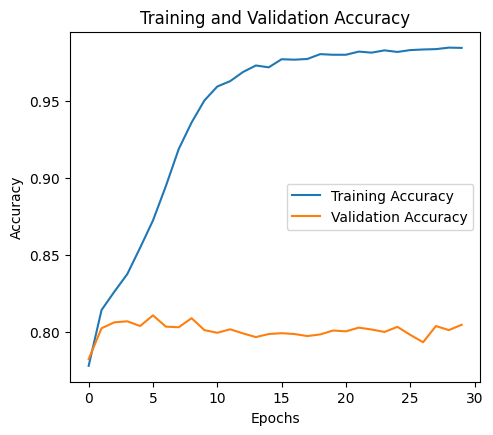

In [33]:
# Accuracy Plot
plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Validation AUC')

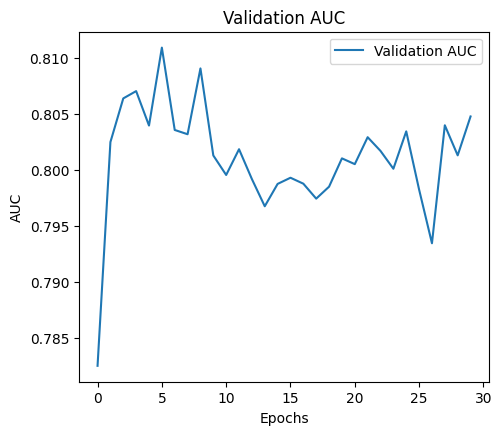

In [35]:
# AUC Plot
plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 4)
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC')

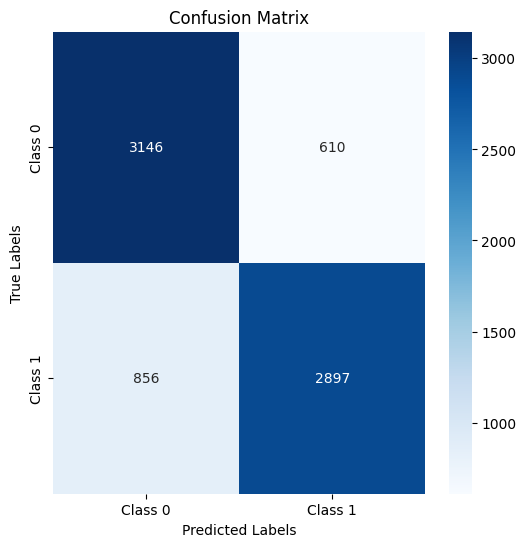

In [30]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
# Confusion Matrix at Final Epoch
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Evaluation
vgg_base.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.float().unsqueeze(1).cuda()
        outputs = vgg_base(inputs)
        predictions = torch.round(outputs).cpu().numpy()
        y_pred.extend(predictions)
        y_true.extend(labels.cpu().numpy())

In [37]:
# Metrics Calculation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

In [38]:
# Print Metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(classification_report(y_true, y_pred))


Accuracy: 0.8048
F1 Score: 0.7981
AUC: 0.8048
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.81      3756
         1.0       0.83      0.77      0.80      3753

    accuracy                           0.80      7509
   macro avg       0.81      0.80      0.80      7509
weighted avg       0.81      0.80      0.80      7509

